# **Text Generation with GPT-2**

This notebook demonstrates the implementation of a Causal Language Model to generate text using the pre-trained [GPT-2](https://huggingface.co/openai-community/gpt2) model developed by [OpenAI](https://github.com/openai/gpt-2) and available on [Hugging Face 🤗](https://huggingface.co/). For fine-tuning, we use the [WikiText-103](https://huggingface.co/datasets/Salesforce/wikitext) dataset, which comprises verified good and featured articles from Wikipedia.

Hugging Face is a platform focused on developing tools and models for natural language processing (NLP). It is known for its open-source library called Transformers, which provides an easy-to-use interface for working with advanced pre-trained NLP models like BERT, T5, GPT, and others.

**Key Points:**
- **Model Architecture:** The GPT-2 model was pre-trained in English, using a causal language modeling objective. It was trained on outbound web pages linked on Reddit that received at least 3 karma points. The model is loaded using the generic class [TFAutoModelForCausalLM](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.TFAutoModelForCausalLM), which allows the creation of an instance of a pre-trained model based on TensorFlow, specifically designed for causal language tasks, including an appropriate classification layer on top. This differs from [TFAutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel), which provides the base model without additional layers.

- **Tokenization:** Hugging Face has implemented a tokenizer for each of its models that returns everything needed for the respective model's inputs. In this case, we use the generic tokenizer [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer), which allows the creation of an instance of the model's tokenizer by name alone. For this text generation task, the text is tokenized, returning `input_ids` (the tokenized sequences) and `attention_mask` (a mask to ignore padding token indices), which are then divided into `seq_length` sized chunks to feed into the model.

- **Using TPU:** Due to the enormous size of the GPT-2 model, which has over 124 million parameters, and the large size of the WikiText-103 dataset, which has 1.81 million rows, it is necessary to use a TPU in Google Colab to significantly accelerate the training process. Although only the classification layer parameters are being fine-tuned, loading and processing pre-trained embeddings along with intensive backpropagation calculations require considerable computational resources. The TPU facilitates efficient handling of these tasks compared to GPUs or CPUs, optimizing performance and training time.

For an implementation with the larger GPT-2 model (GPT-2 XL), visit my next [notebook](https://github.com/JersonGB22/CausalLanguageModeling-TensorFlow/blob/main/models_transformers/CausalLM_GPT2-XL.ipynb).

## **Imports**

In [ ]:
!pip install datasets -q

In [4]:
import tensorflow as tf
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from transformers import TFAutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
import re
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML
from tqdm.auto import tqdm

## **Parameters**

In [5]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [6]:
epochs = 5
batch_size = 64
buffer_size = 1024
seq_length = 512
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

model_name = "gpt2"
train_filename = "/content/drive/MyDrive/Datasets/train_clm_gpt2.tfrecord"
val_filename = "/content/drive/MyDrive/Datasets/val_clm_gpt2.tfrecord"
test_filename = "/content/drive/MyDrive/Datasets/test_clm_gpt2.tfrecord"

## **Preprocessing and Saving Data in TFRecord Format**

Given that the WikiText-103 training dataset is large and the GPT-2 model is also substantial, the data is preprocessed, tokenized, and stored in TFRecord format. This enables truly massive data pipeline performance for training on Colab's TPU. This process has become more accessible because it is no longer necessary to store TFRecord files in Google Cloud Storage due to the new version of Colab's TPU, `TPU v2`, which has [transitioned from TPU Node to TPU VM](https://github.com/googlecolab/colabtools/issues/4481).

### **Load and Preprocess the Dataset**

In [ ]:
dataset = load_dataset("wikitext", "wikitext-103-raw-v1")
dataset

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [ ]:
# See an example of the training dataset
dataset["train"][3]

{'text': ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n'}

**Import the AutoTokenizer**

In [ ]:
# 'use_fast=True': improves the tokenizer's performance when processing large volumes of text

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
# Example of tokenization

id = 3
example = dataset["train"][id]
print("Text:\n", example["text"], "\n")

encoding = tokenizer(example["text"])

input_ids = encoding["input_ids"]
print("Input Ids:\n", input_ids, "\n")
print("Tokens:\n", tokenizer.convert_ids_to_tokens(input_ids), "\n")
print("Decoded Text:\n", tokenizer.decode(input_ids), "\n")

print("Attention Mask:\n", encoding["attention_mask"])

Text:
  Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 
 

Input Ids:
 [2311, 73, 13090, 645, 569, 18354, 7496, 513, 1058, 791, 47398, 17740, 357, 4960, 1058, 10545, 230, 99, 161, 254, 112, 5641, 44444, 9202, 25084, 24440, 12675, 11839, 18, 837, 6578, 764, 569, 18354, 7496, 286, 262, 30193, 513, 1267, 837, 8811, 6412, 284, 355, 569, 18354, 7

In [ ]:
# All headings are between 1 or more '=' signs

print(dataset["train"]["text"][:3], "\n")
print(dataset["train"]["text"][-9:-6])

['', ' = Valkyria Chronicles III = \n', ''] 

['', ' = = Bungie = = \n', '']


**Tokenization**

In [ ]:
def tokenize_dataset(dataset):
  texts = dataset["text"]
  clean_texts = []

  # The first and the last element are empty strings
  for text in texts:
    # Remove the headers
    if not re.search(r" =+ (.+?) =+ \n", text):
      # Remove the '@' from characters such as '@-@', '@,@', '@.@'
      text = re.sub(r"\s@([^\s@])@\s", r"\1", text)
      clean_texts.append(text)

  return tokenizer(clean_texts)


def create_sequences(dataset, seq_length=seq_length):
  # Concatenate 'input_ids' and 'attention_mask' into single lists each
  dataset = {k: sum(v, []) for k, v in dataset.items()}

  # Create sequences of size 'seq_length + 1'
  seq_length += 1
  total_length = (len(dataset["input_ids"]) // seq_length) * seq_length
  dataset = {
      k: [v[i: i+seq_length] for i in range(0, total_length, seq_length)]
      for k, v in dataset.items()
  }

  return dataset

In [ ]:
dataset = dataset.map(tokenize_dataset, batched=True, remove_columns=["text"])

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1040 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.map(create_sequences, batched=True)
dataset

Map:   0%|          | 0/3652 [00:00<?, ? examples/s]

Map:   0%|          | 0/1496269 [00:00<?, ? examples/s]

Map:   0%|          | 0/3140 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 525
    })
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 218833
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 458
    })
})

### **Saving Data in TFRecord Format**

In [ ]:
def save_tfrecord(filename, dataset):
  with tf.io.TFRecordWriter(filename) as writer:
    for dic in tqdm(dataset):
      features = {
          "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=dic["input_ids"])),
          "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=dic["attention_mask"])),
      }

      features = tf.train.Features(feature=features)
      example = tf.train.Example(features=features).SerializeToString()
      writer.write(example)

In [ ]:
save_tfrecord(train_filename, dataset["train"])
save_tfrecord(val_filename, dataset["validation"])
save_tfrecord(test_filename, dataset["test"])

  0%|          | 0/218833 [00:00<?, ?it/s]

  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

## **Using the TPU for Training**

Using a TPU is essential for training the model, as each epoch takes approximately 25 minutes to complete, even with its use.

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


### **Loading the Preprocessed Datasets**

In [ ]:
train_size, val_size, test_size = 218833, 458, 525

In [ ]:
def decode_tfrecord(sample):
  features = {
      "input_ids": tf.io.FixedLenFeature((seq_length+1, ), tf.int64),
      "attention_mask": tf.io.FixedLenFeature((seq_length+1, ), tf.int64)
  }

  parsed_features = tf.io.parse_example(sample, features)
  input_ids = parsed_features["input_ids"]
  attention_mask = parsed_features["attention_mask"]

  return input_ids, attention_mask


def split_input_label(input_ids, attention_mask):
  inputs = input_ids[:-1]
  labels = input_ids[1:] #The 'labels' are simply the 'ids' shifted one position to the right
  return (inputs, attention_mask[:-1]), labels


def load_dataset(filename, size, shuffle=False):
  dataset = tf.data.TFRecordDataset(filename)
  dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(size))

  dataset = dataset.map(split_input_label, num_parallel_calls=AUTOTUNE)
  if shuffle:
    dataset = dataset.shuffle(buffer_size, seed=SEED)
  dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

  return dataset

In [ ]:
train_dataset = load_dataset(train_filename, train_size, shuffle=True)
val_dataset = load_dataset(val_filename, val_size)
test_dataset = load_dataset(test_filename, test_size)

In [ ]:
# Viewing a training batch
for (ids, masks), labels in train_dataset.take(1):
  print(ids, "\n")
  print(masks, "\n")
  print(labels)

tf.Tensor(
[[ 2712 14104  1830 ...   290  2237  9089]
 [  366   764  4705 ...   366   290 24998]
 [ 2168  1626   262 ... 39790  2743   645]
 ...
 [ 2594   389   991 ...  2476   319   262]
 [  408   837 31049 ...   764   220   198]
 [  319   262  3942 ... 13804   290  2574]], shape=(64, 512), dtype=int64) 

tf.Tensor(
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]], shape=(64, 512), dtype=int64) 

tf.Tensor(
[[14104  1830   329 ...  2237  9089   764]
 [  764  4705 11294 ...   290 24998   326]
 [ 1626   262   569 ...  2743   645   367]
 ...
 [  389   991  8941 ...   319   262  2323]
 [  837 31049   290 ...   220   198 14303]
 [  262  3942  3159 ...   290  2574  3549]], shape=(64, 512), dtype=int64)


### **Creation and Training of the Model**


In [ ]:
# Callback to stop training early if validation loss does not decrease for 1 epoch
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    mode="min",
    restore_best_weights=True
)

In [ ]:
def create_model():
  # Import the AutoModel
  model_base = TFAutoModelForCausalLM.from_pretrained(model_name)

  input_ids = tf.keras.Input((seq_length, ), dtype=tf.int64)
  attention_mask = tf.keras.Input((seq_length, ), dtype=tf.int64)
  logits = model_base(input_ids=input_ids, attention_mask=attention_mask).logits

  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

# Creation and compilation of the model within the distribution strategy
with strategy.scope():
  model = create_model()

  model.compile(
      optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      steps_per_execution=400
  )

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 tfgpt2lm_head_model (TFGPT  TFCausalLMOutputWithCrossA   1244398   ['input_1[0][0]',             
 2LMHeadModel)               ttentions(loss=None, logit   08         'input_2[0][0]']             
                             s=(None, 512, 50257),                                                
                              past_key_values=((2, None                                       

In [ ]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/5
3420/3420 [==============================] - 1631s 477ms/step - loss: 3.2770 - val_loss: 3.1168
Epoch 2/5
3420/3420 [==============================] - 1491s 436ms/step - loss: 3.1921 - val_loss: 3.0755
Epoch 3/5
3420/3420 [==============================] - 1491s 436ms/step - loss: 3.1519 - val_loss: 3.0495
Epoch 4/5
3420/3420 [==============================] - 1491s 436ms/step - loss: 3.1228 - val_loss: 3.0293
Epoch 5/5
3420/3420 [==============================] - 1491s 436ms/step - loss: 3.0994 - val_loss: 3.0136


### **Save model**

In [7]:
trained_model_path = "/content/drive/MyDrive/models/CausalLM_GPT-2_WikiText-103"

In [ ]:
model.layers[2].save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
loss_train = model.evaluate(train_dataset, verbose=0)
loss_val = model.evaluate(val_dataset, verbose=0)
loss_test = model.evaluate(test_dataset, verbose=0)

print(f"Training Dataset:\nLoss: {loss_train}\tPerplexity: {np.exp(loss_train)}\n")
print(f"Validation Dataset:\nLoss: {loss_val}\tPerplexity: {np.exp(loss_val)}\n")
print(f"Testing Dataset:\nLoss: {loss_test}\tPerplexity: {np.exp(loss_test)}")

Training Dataset:
Loss: 2.9825522899627686	Perplexity: 19.73812984119433

Validation Dataset:
Loss: 3.0135679244995117	Perplexity: 20.35991312034335

Testing Dataset:
Loss: 2.9992434978485107	Perplexity: 20.07034791727367


The perplexity (PPL) on the evaluation set was observed to be **20.36** after only 5 epochs, indicating successful fine-tuning, as the untuned GPT-2 model achieved a [PPL of 37.5](https://huggingface.co/openai-community/gpt2#evaluation-results) on the WikiText-103 dataset. This achieved result is close to that of GPT-2 XL, the larger version of GPT-2 with over 1.5 billion parameters, which achieved a [PPL of 17.48](https://huggingface.co/openai-community/gpt2-xl#results) without any fine-tuning. As observed, the training was not stopped by the callback because the validation loss continued to decrease, suggesting that a PPL even lower than 20.36 could be achieved with more than 5 epochs of training.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()

**Images for GitHub**

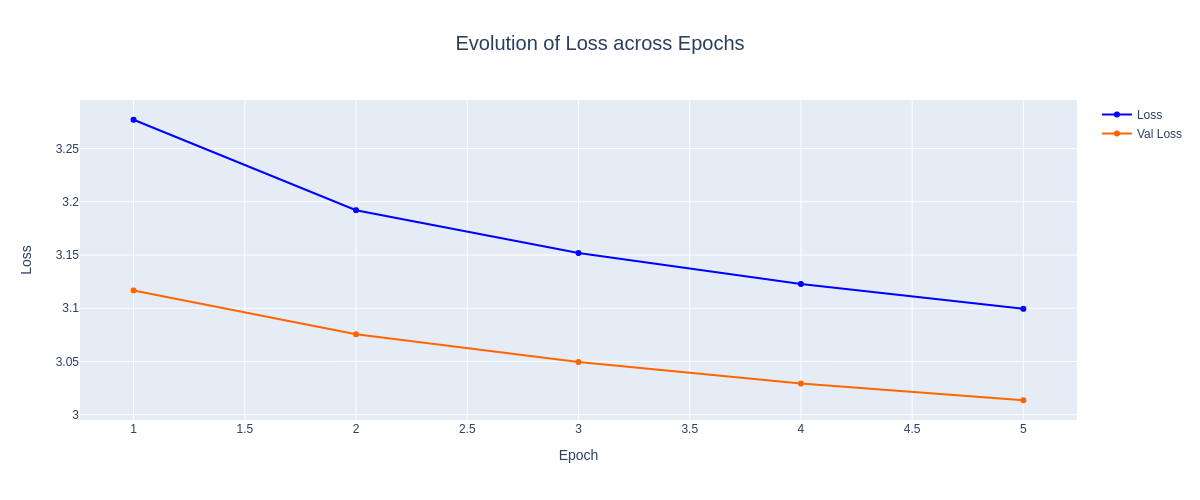

In [ ]:
plot_metrics(renderer="png")

## **Text Generation with the Trained Model**

In [8]:
# Load the trained model
tf.keras.backend.clear_session()
model = TFAutoModelForCausalLM.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/models/CausalLM_GPT-2_WikiText-103.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


For text generation, sampling methods such as top-p and top-K are often more effective than Greedy and Beam Search methods, as indicated in the following [Hugging Face article](https://huggingface.co/blog/how-to-generate), for producing more natural text and reducing repetitions. Additionally, maintaining text coherence requires crucial adjustment of the ``softmax temperature``. Therefore, in this case, the following parameter values are considered optimal for text generation:

```
- temperature = 0.75
- top_k = 50
- top_p = 0.9
```

In [ ]:
def generate_text(prefix=" ", num_tokens=50, temperature=0.75, n_generations=3):
  inputs = tokenizer(prefix, return_tensors="tf")

  preds = model.generate(
      **inputs,
      max_length=num_tokens,
      do_sample=True, #Activates Sampling for text generation
      temperature=temperature,
      top_k=50,
      top_p=0.9,
      repetition_penalty=1.2, #Slight penalty to avoid repetitions
      num_return_sequences=n_generations, #Generate n results

  )

  for i, pred in enumerate(preds, 1):
    pred = tokenizer.decode(pred)
    #Replace '\n' with '<br><br>' to make the line break visible in HTML format
    pred = pred.replace("\n", "<br><br>")
    # Shade the prefix in yellow
    pred = f"<span style='background-color: yellow;'>{pred[:len(prefix)]}</span>{pred[len(prefix):]}"
    # Add '...' to indicate that the generation can continue
    pred += "..."

    display((HTML(f"""
    <div style="width: 500px;">
      <b>GENERATED TEXT {i}:</b><br>{pred}<br><br>
    </div>
    """)))

In [ ]:
generate_text(
    prefix="During the Renaissance, artists and thinkers",
    n_generations=2
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
generate_text(
    prefix="Genetic engineering has revolutionized modern biology",
    num_tokens=100
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
generate_text(
    prefix="In the vast expanse of the universe, black holes are",
    num_tokens=200
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
generate_text(
    prefix="The impact of globalization on emerging markets",
    num_tokens=250,
    n_generations=2
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
generate_text(
    prefix="In the field of technology",
    num_tokens=300,
    n_generations=1
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**Conclusion:** The fine-tuned model generates text with considerable coherence, delves into the proposed topic (prefix), has minimal spelling errors, and produces highly relevant content in various fields such as history, art, philosophy, technology, economics, etc., topics covered in WikiText-103. However, the facts generated by the model are largely fictitious. The accuracy of the facts could improve along with the quality of the generation if the model were trained for more epochs to achieve a lower loss, or if a more robust model such as GPT-2 XL were used. Nevertheless, the generation will always contain some degree of fiction.